# Lecture 15
_____________


In [42]:
import numpy as np 
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600
import seaborn as sns
sns.set_style('whitegrid')
from platypus import NSGAII, Problem, Real

## _Policy search and multiobjective function_

In [43]:
K = 975 # capacity, TAF
D = 150 # target yield, TAF
a = 0.35
b = 2.3 # cost function parameters

In [44]:
Q = np.loadtxt('data/FOL-monthly-inflow-TAF.csv', delimiter=',', skiprows=1, usecols=[1])
T = len(Q)

Same function, but now returns 2 objectives

In [45]:
def simulate(x):
    S = np.zeros(T)
    R = np.zeros(T)
    cost = np.zeros(T)
    h0 = x[0]
    hf = x[1]
    
    S[0] = K # start simulation full
    reliability = 0

    for t in range(1,T):
        
        # new storage: mass balance, max value is K
        S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)
        
        # determine R from hedging policy
        W = S[t] + Q[t]
        if W > hf:
            R[t] = D
            reliability += 1.0/T
        elif W < h0:
            R[t] = W
        else:
            R[t] = (D-h0)/(hf-h0)*(W-h0)+h0

        shortage = D-R[t]
        cost[t] = a*shortage**b

    return [cost.mean(), reliability]

Define the problem. Objects `Problem` and `Real` are imported above from `platypus`

In [46]:
# Problem(number of decisions, number of objectives)
problem = Problem(2, 2)
problem.types[0] = Real(0,D)
problem.types[1] = Real(D,K+D)
problem.directions[1] = Problem.MAXIMIZE
problem.function = simulate

In [47]:
algorithm = NSGAII(problem)

Optimize the problem using 10000 function evaluations

In [48]:
algorithm.run(10000)

Just plotting below here

Convert results to numpy arrays

In [49]:
obj = np.array([s.objectives for s in algorithm.result])
x = np.array([s.variables for s in algorithm.result])

To make a contour plot...

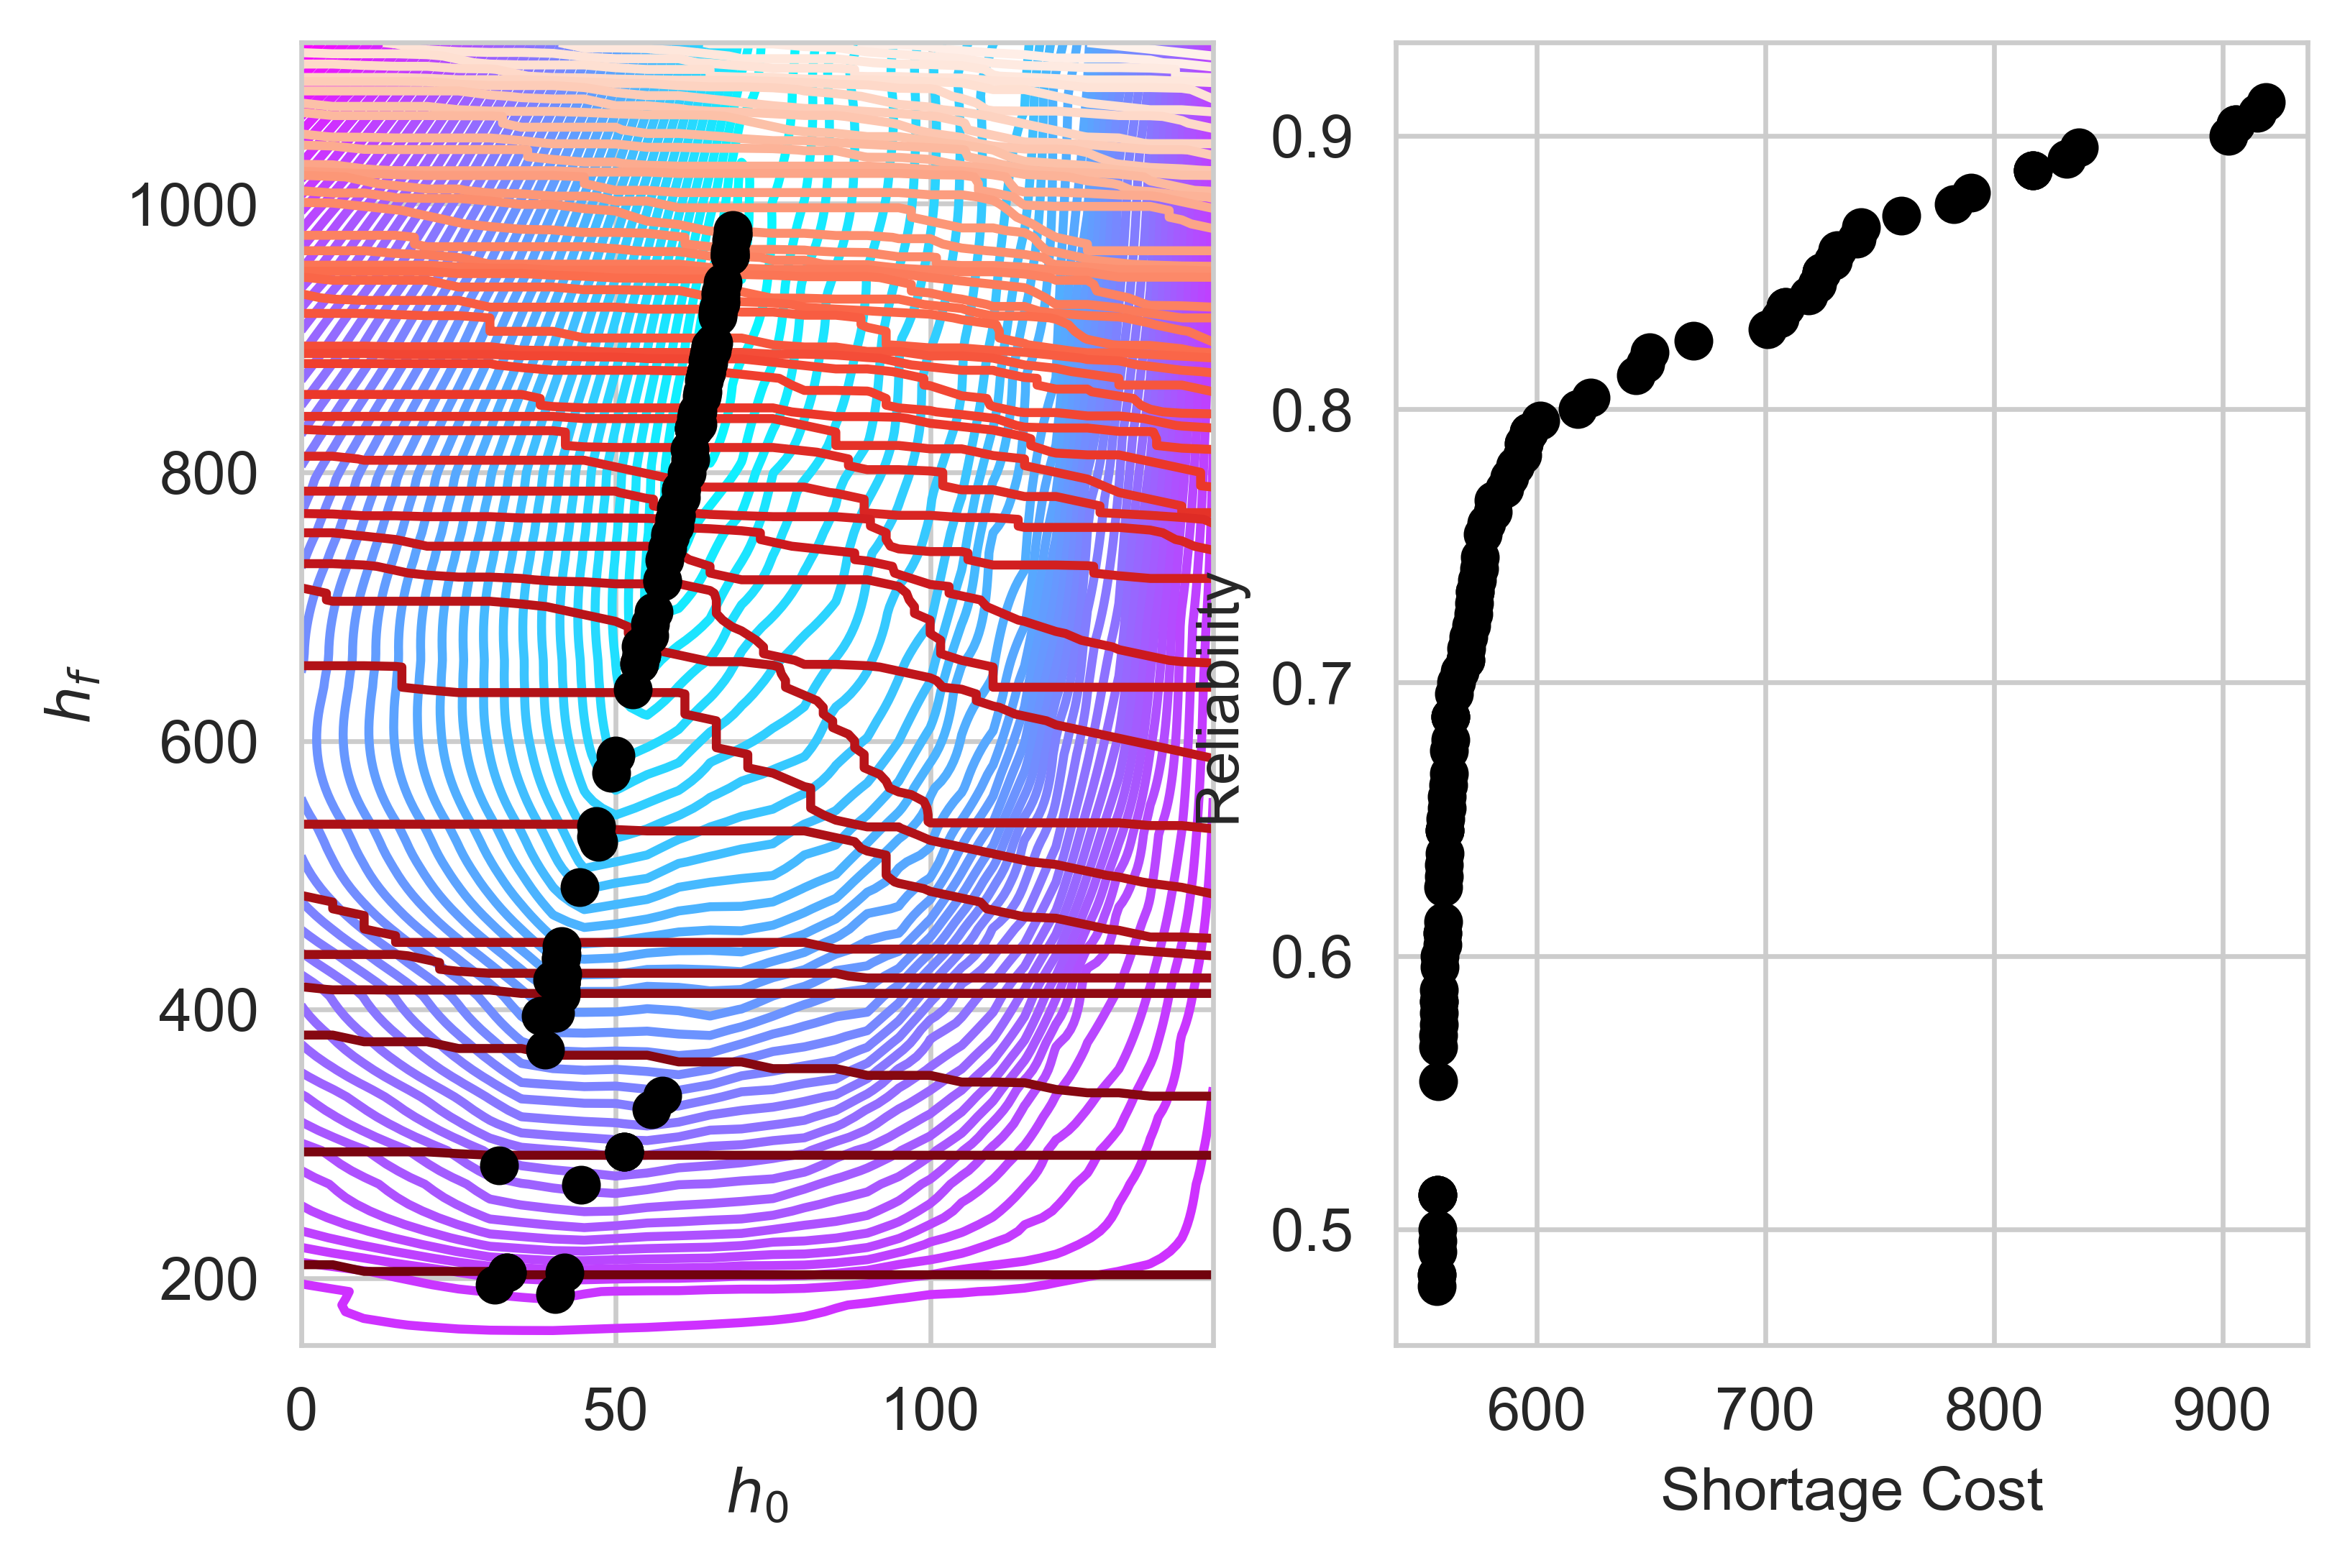

In [50]:
h0s = np.arange(0,D,5)
hfs = np.arange(D,K+D,5)
X,Y = np.meshgrid(h0s, hfs)
costs = np.zeros((len(h0s),len(hfs)))
rels = np.zeros((len(h0s),len(hfs)))
i,j = 0,0

# fill in matrices for contour plot
for i,h0 in enumerate(h0s):
    for j,hf in enumerate(hfs):
        costs[i,j],rels[i,j] = simulate([h0,hf])

plt.subplot(1,2,1)
plt.contour(X,Y,costs.T, 50, cmap=plt.cm.cool)
plt.contour(X,Y,rels.T, 50, cmap=plt.cm.Reds)
plt.scatter(x[:,0],x[:,1], s=30, color='k', zorder=5)
plt.xlabel(r'$h_0$')
plt.ylabel(r'$h_f$')

plt.subplot(1,2,2)
plt.scatter(obj[:,0],obj[:,1], s=30, color='k')
plt.xlabel('Shortage Cost')
plt.ylabel('Reliability')

plt.show()

-----------

## _Multiobjective plotting_

Visualizing Pareto fronts for decision support
 - N-dimensional scatter plots
 - Parallel axis plots

Load a 4-objective pareto front

In [51]:
data = np.loadtxt('data/example-pareto-front.csv', delimiter=',')

__Example 1:__ N-dimensional scatter plot. These plots in JupyterLab are not interactive, but using different tools would allow zoom/rotation.

In [54]:
from mpl_toolkits.mplot3d import Axes3D

/var/folders/3q/q4pw14qn3r95vp8fslqnfl340000gn/T/ipykernel_13392/4247506729.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(h)


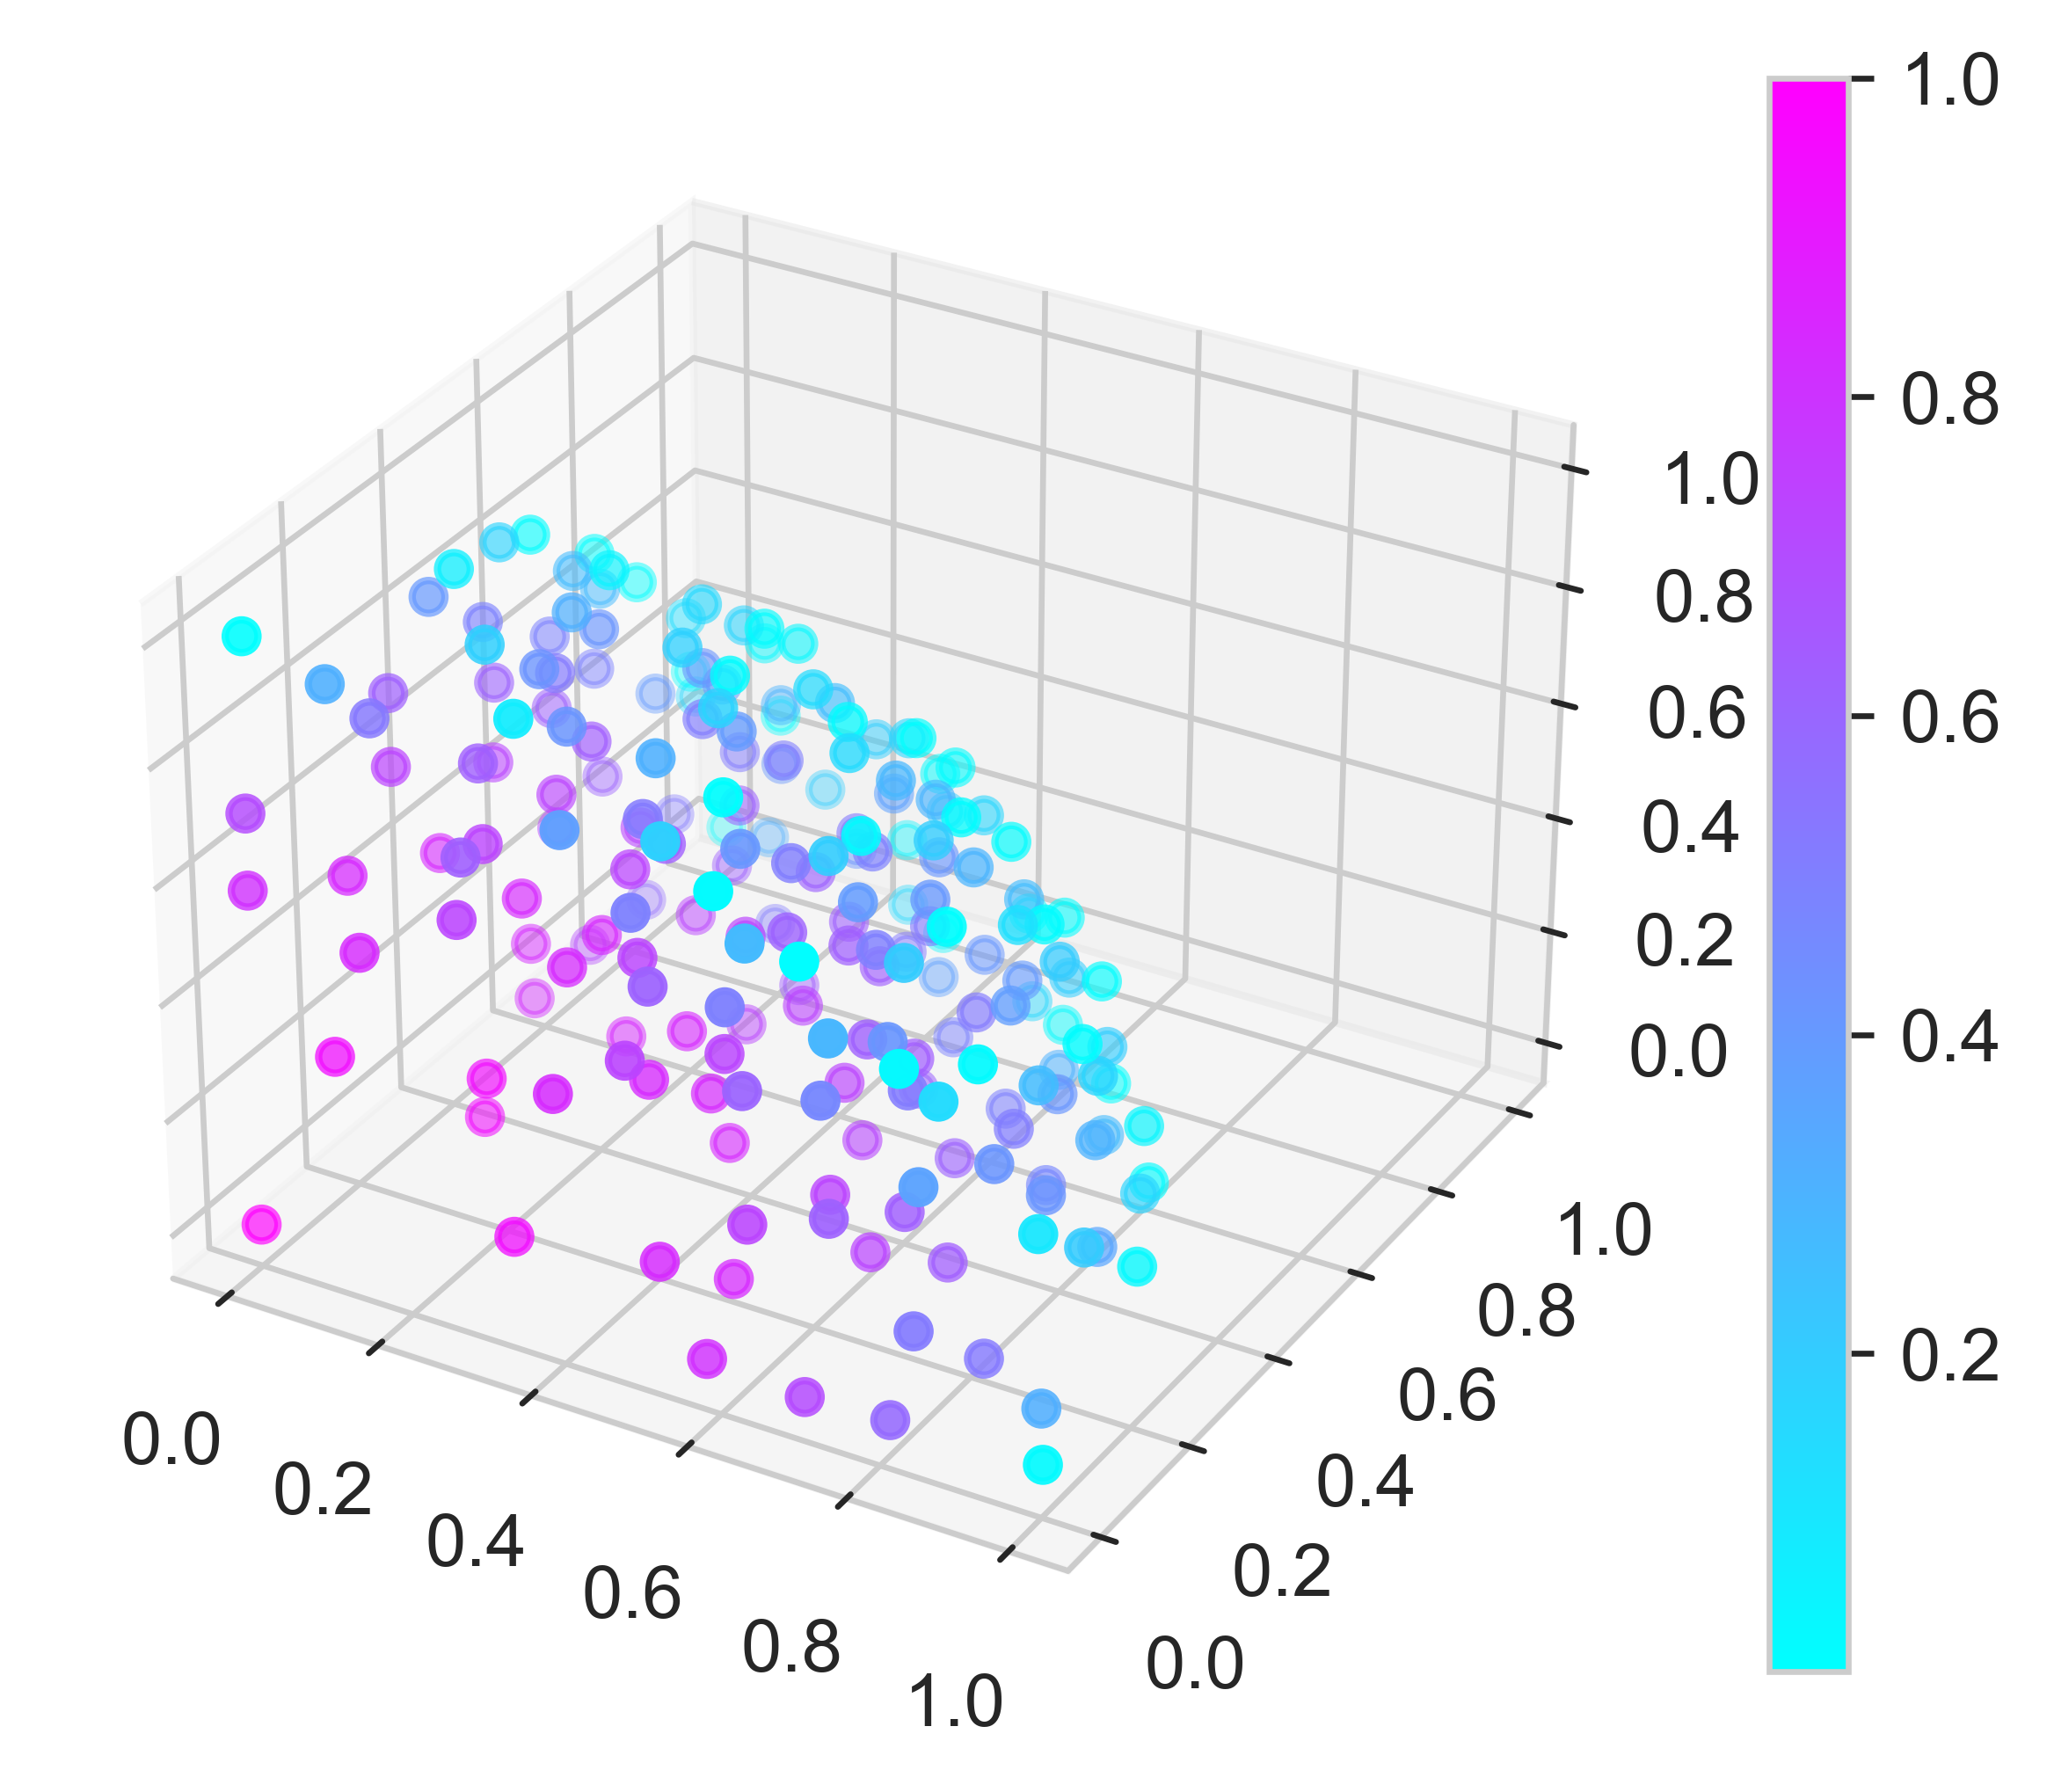

In [55]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# use 's' and 'c' for size/color, respectively
h = ax.scatter(data[:,0], data[:,1], data[:,2], 
           c=data[:,3], cmap=plt.cm.cool) 
           #s=50*data[:,0], edgecolor='none')

plt.colorbar(h)
plt.show()

__Example 2:__ parallel axis
    
See also: http://syntagmatic.github.io/parallel-coordinates/examples/table.html

First normalize each objective to [0,1] range

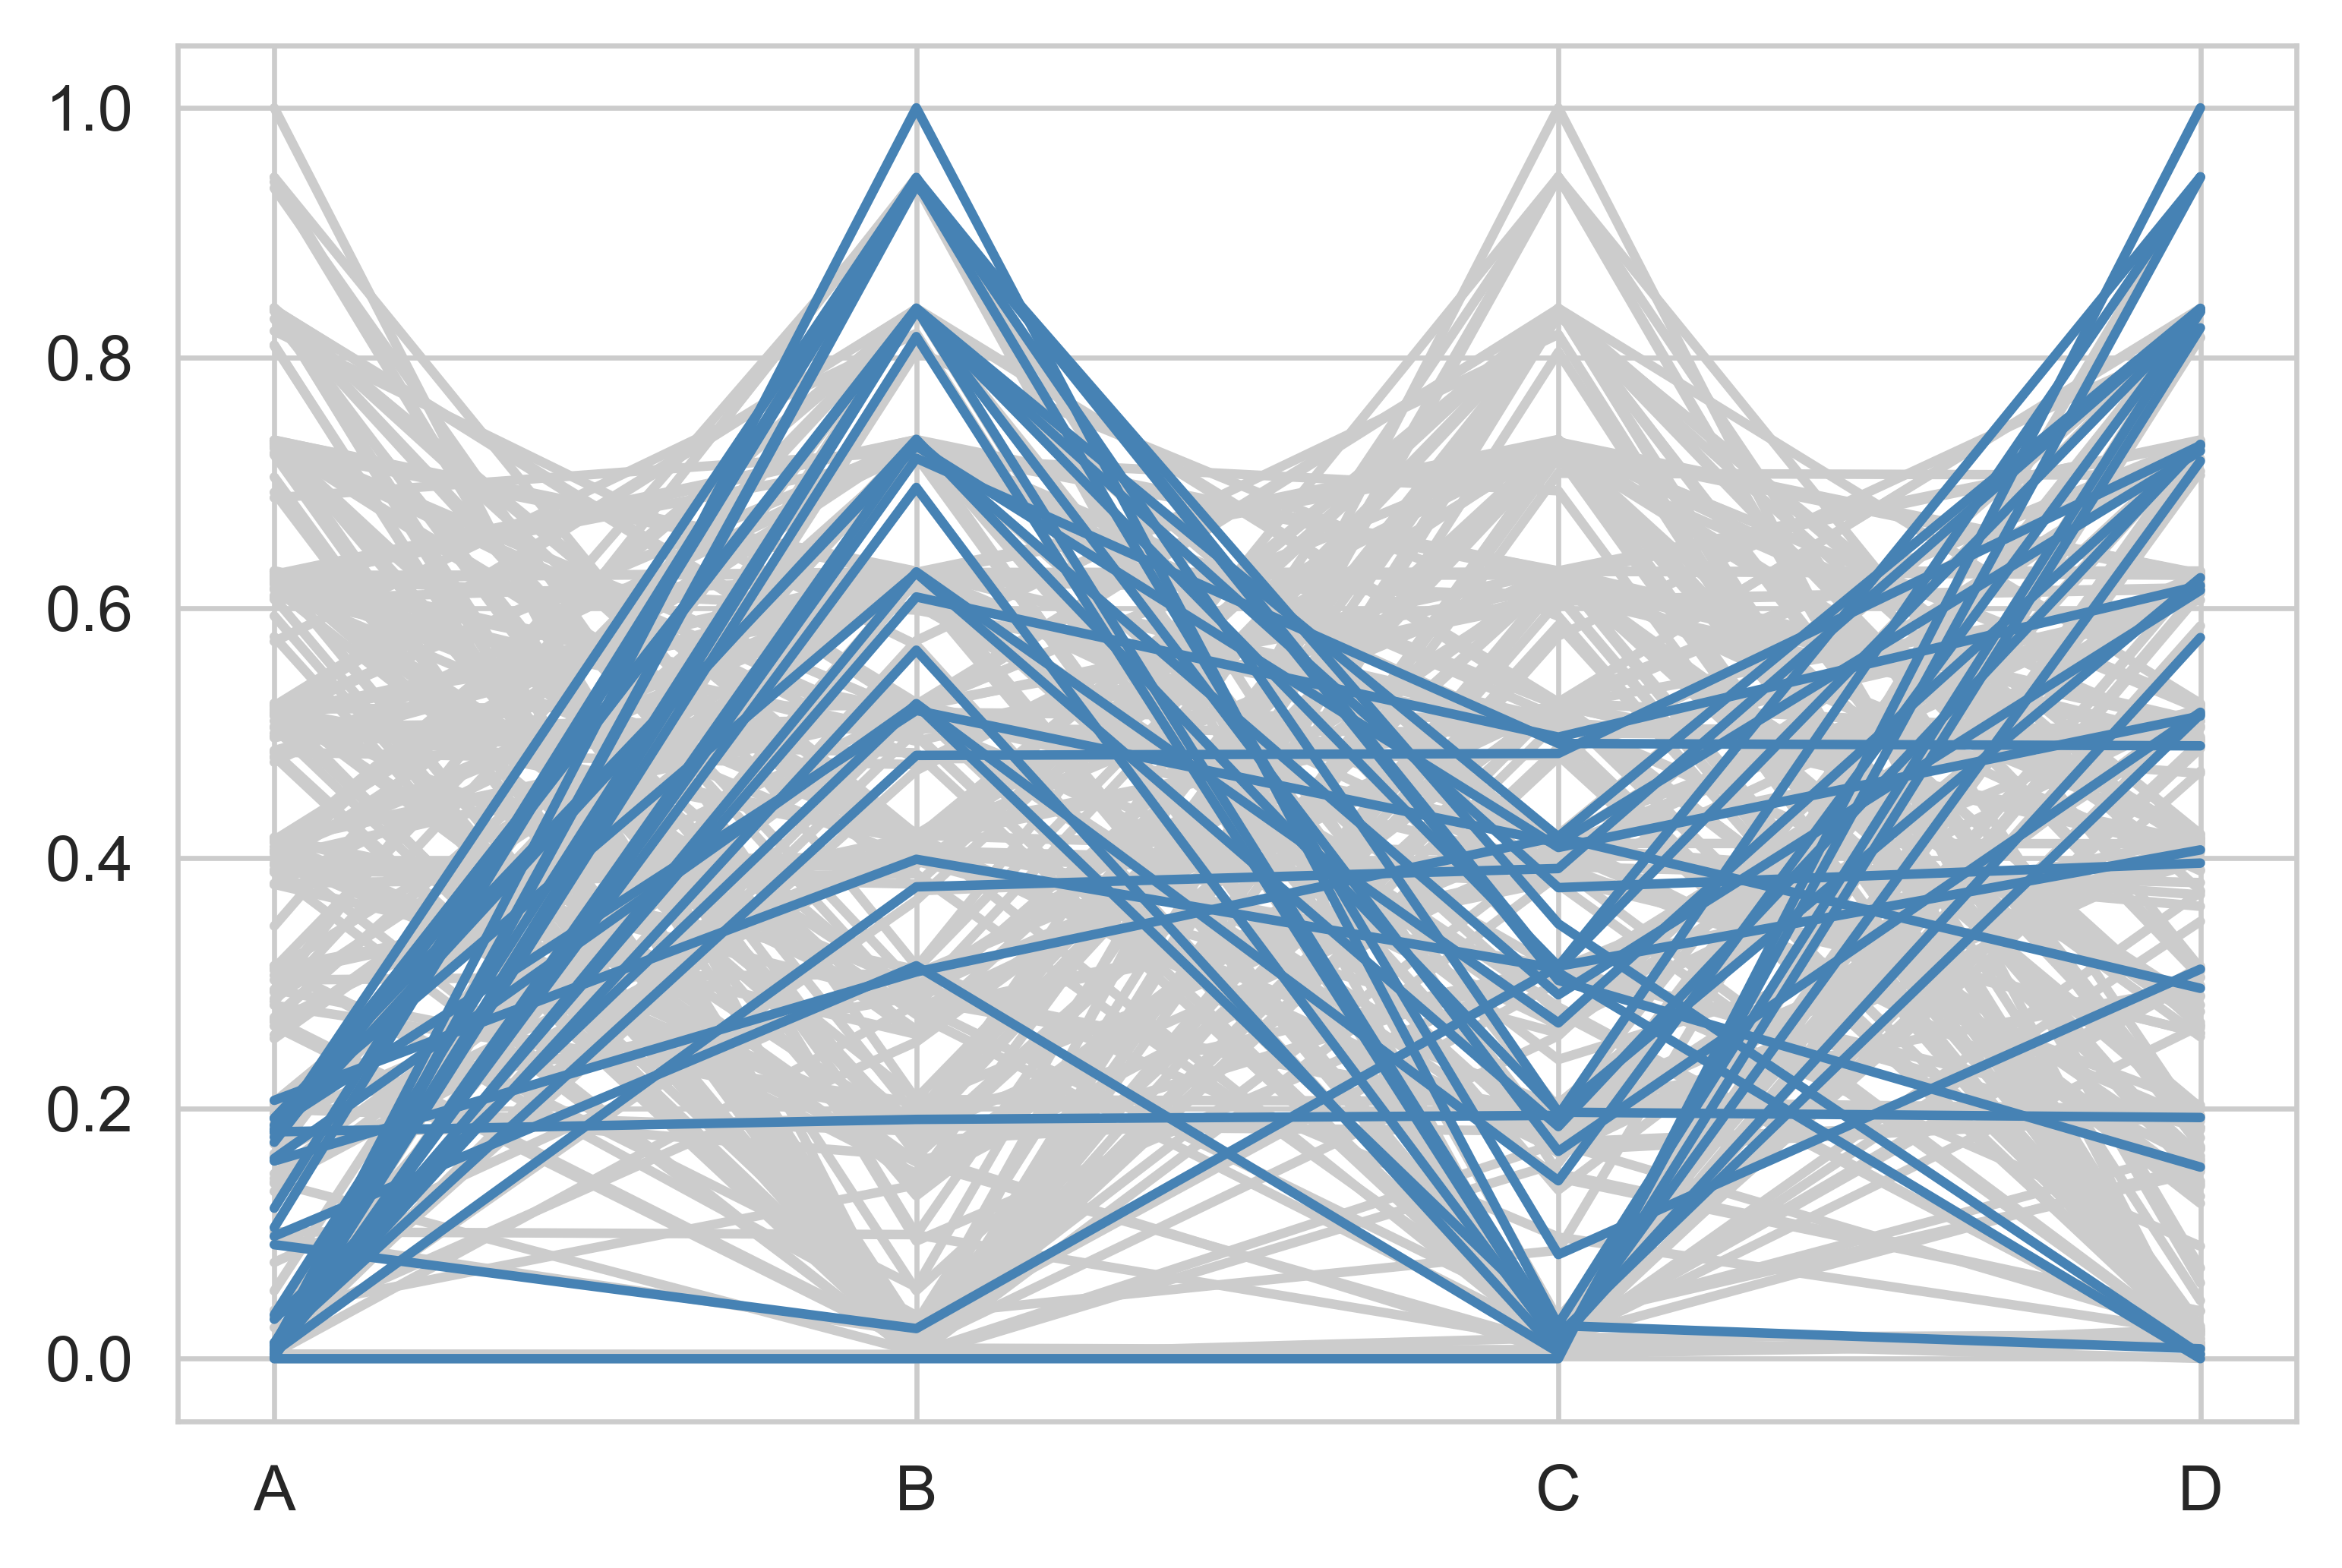

In [56]:
for objs in data:
    objs = (objs - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

    # filtering
    if objs[2] < 0.5 and objs[0] < 0.25:
        plt.plot(range(4), objs, color='steelblue', zorder=2)
    else:
        plt.plot(range(4), objs, color='0.8', zorder=1)

plt.gca().set_xticks(range(4))
plt.gca().set_xticklabels(['A','B','C','D'])
plt.show()

__Example 3:__ scatter plot matrix

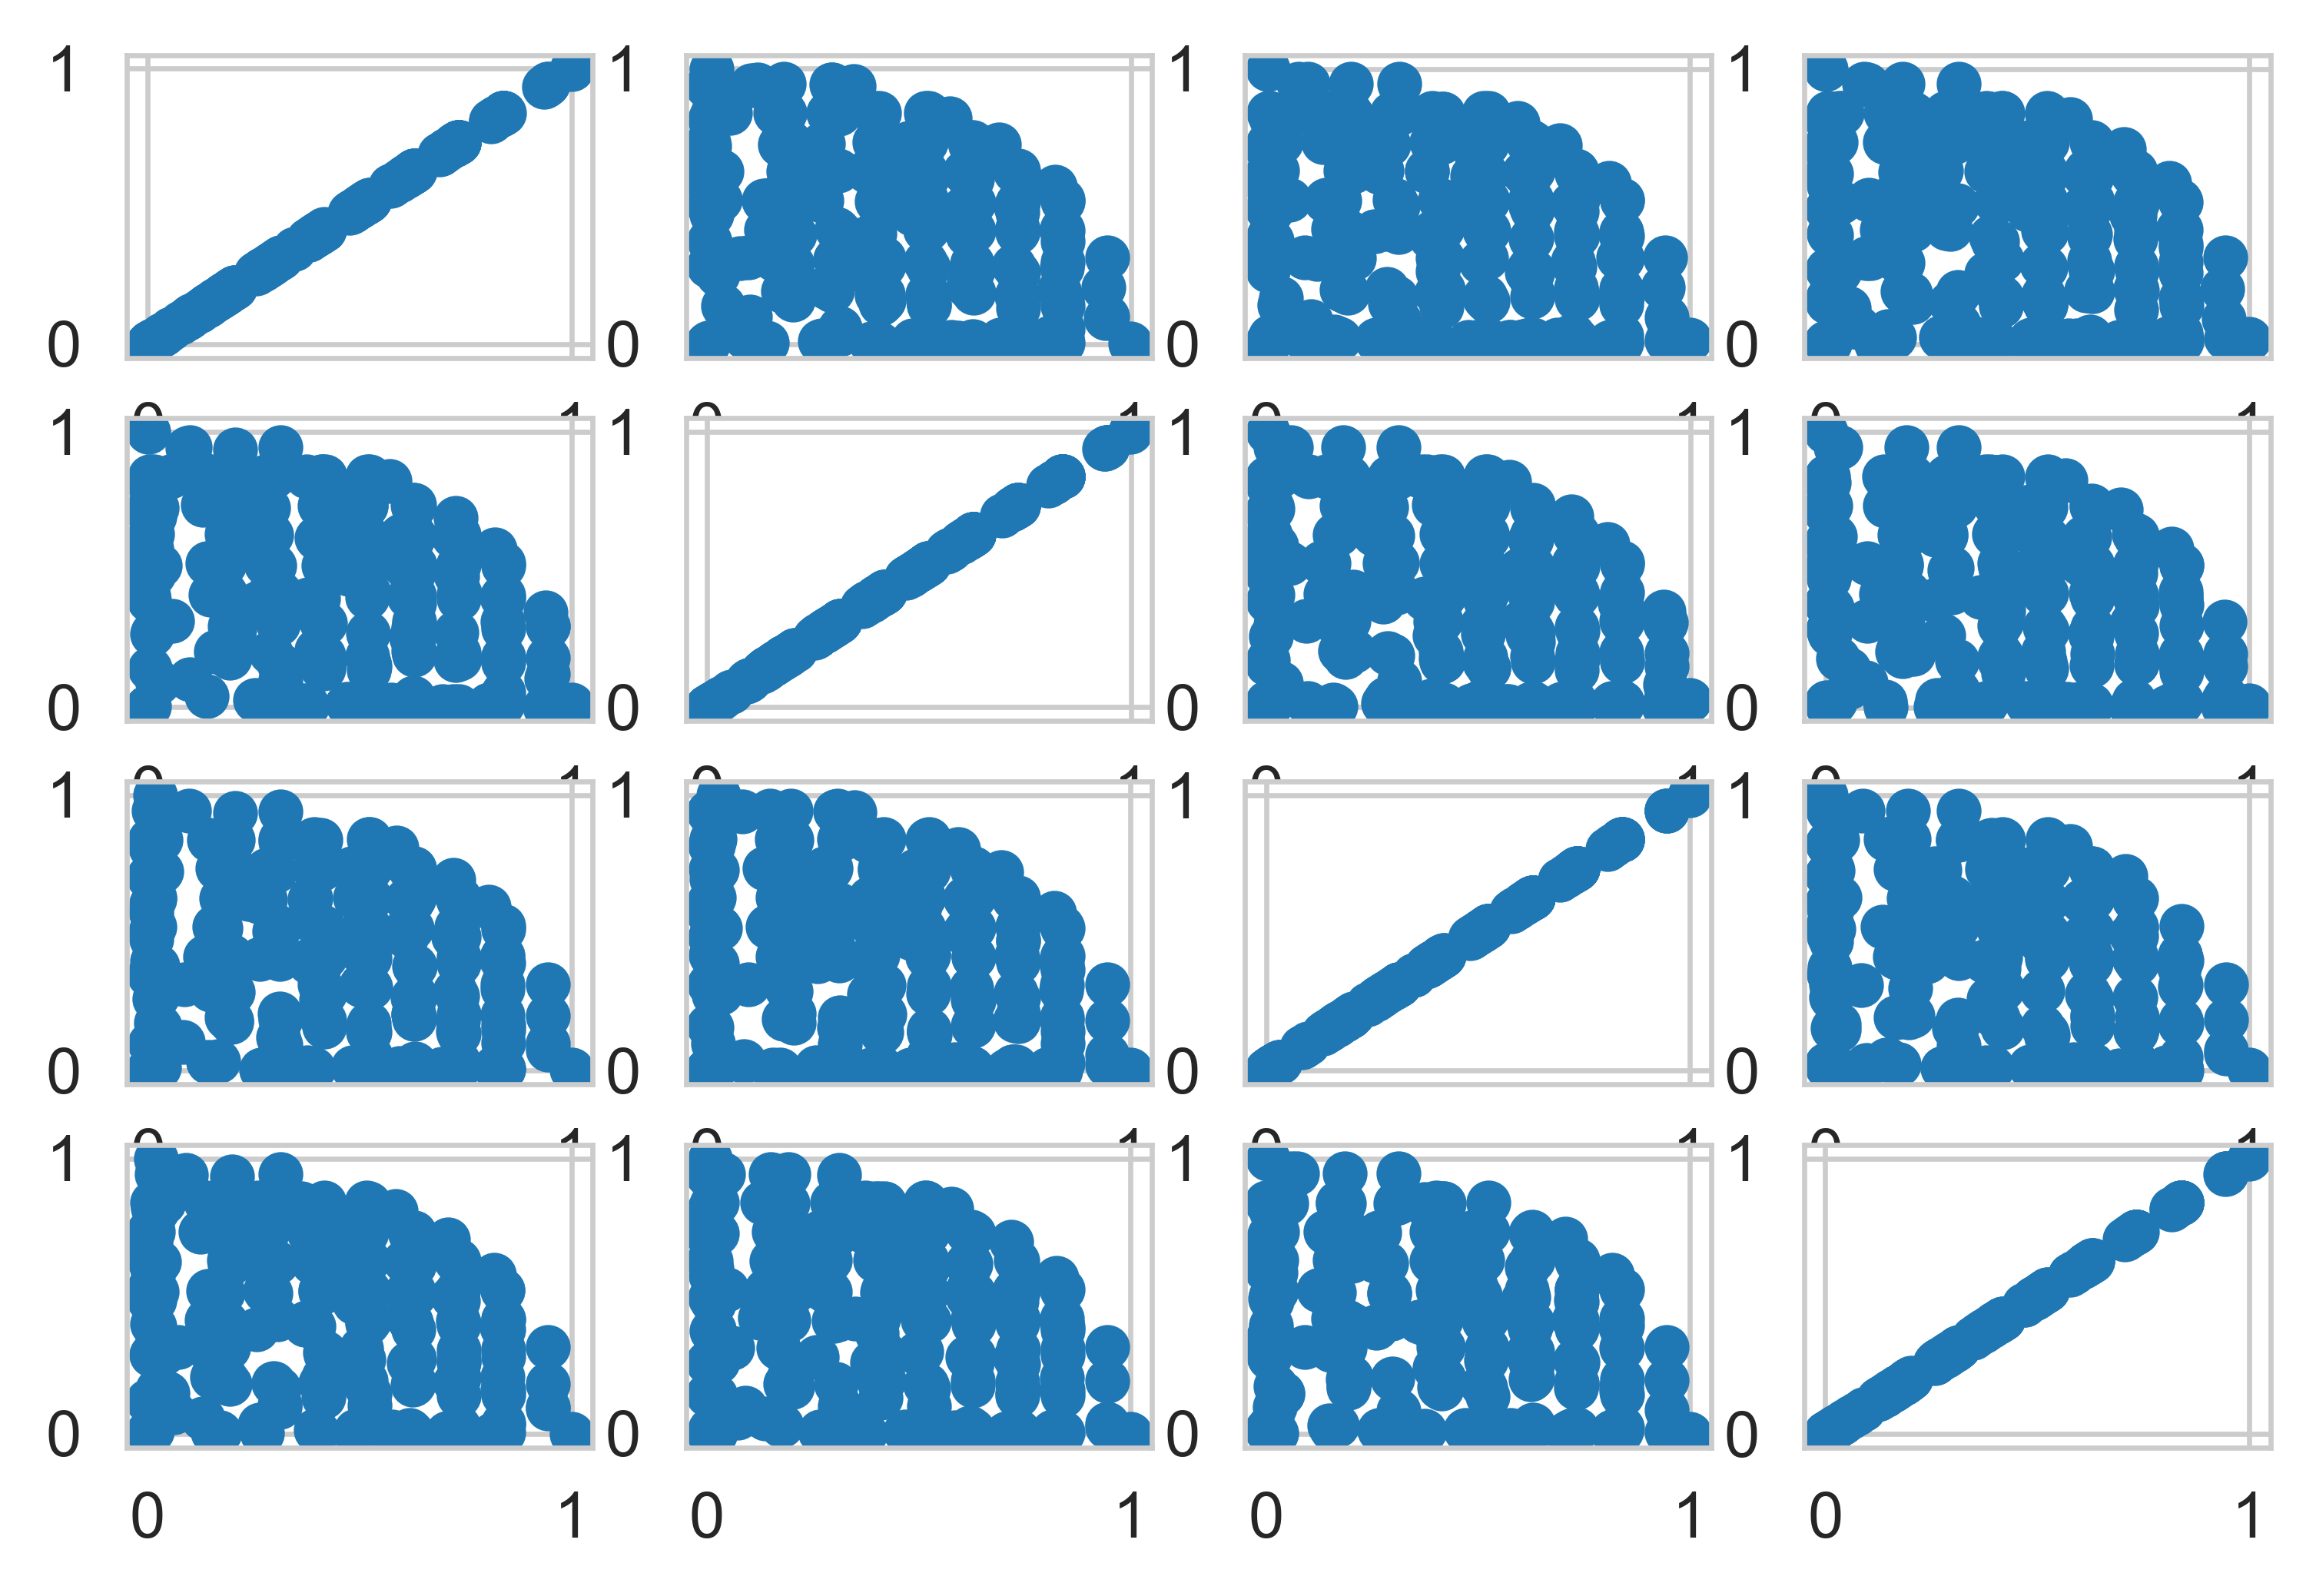

In [57]:
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        
        plt.scatter(data[:,i], data[:,j])

plt.show()

-----------